# Visualizing PhysioNet EEG During Mental Arithmetic Tasks

This notebook demonstrates how to download, load, and visualize EEG data from the PhysioNet EEG During Mental Arithmetic Tasks dataset.

## Dataset Information

The EEG During Mental Arithmetic Tasks dataset contains 23-channel EEG data from 36 subjects before and during mental arithmetic tasks. The dataset is available at:
https://physionet.org/content/eegmat/1.0.0/

**Note**: The dataset uses the EDF format (European Data Format), which is common for physiological signals.

## Dataset Details:
- **Subjects**: 36 volunteers
- **Channels**: 23 EEG channels (10/20 system)
- **Sampling Rate**: ~500 Hz (varies by subject)
- **Tasks**:
  - **Condition 1**: Baseline/resting state EEG (60 seconds)
  - **Condition 2**: Mental arithmetic task - serial subtraction of 2-digit from 4-digit numbers (60 seconds)
- **Format**: EDF (European Data Format)
- **Frequency Band**: This analysis focuses on **Beta band (13-30 Hz)**, associated with active thinking and concentration

## Requirements

Before running this notebook, make sure you have the following packages installed:

```bash
pip install numpy matplotlib scipy mne requests
```

## 0. Install all Required Libraries

In [73]:
!pip install numpy matplotlib scipy mne requests seaborn --quiet

## 1.1 Import Required Libraries

In [74]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import mne
from pathlib import Path
from scipy import stats
import seaborn as sns
from scipy.signal import hilbert

# Set plotting style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    plt.style.use('default')
    print("Note: Using default matplotlib style")

%matplotlib inline

print("Libraries imported successfully!")
print(f"MNE version: {mne.__version__}")

Libraries imported successfully!
MNE version: 1.11.0


## 1.2 Configuration

Set up the analysis parameters:

In [75]:
# Beta band frequency range (13-30 Hz)
BETA_BAND = (13, 30)

# Subjects to analyze (editable)
SUBJECTS = ['Subject00', 'Subject01', 'Subject02']

# Data directory
DATA_DIR = Path('eeg_data')
DATA_DIR.mkdir(exist_ok=True)

print(f"Beta band: {BETA_BAND[0]}-{BETA_BAND[1]} Hz")
print(f"Analyzing {len(SUBJECTS)} subjects: {', '.join(SUBJECTS)}")

Beta band: 13-30 Hz
Analyzing 3 subjects: Subject00, Subject01, Subject02


## 2. Download EEG Data from PhysioNet

Download data files from PhysioNet for each subject (both baseline and task conditions):

In [76]:
base_url = 'https://physionet.org/files/eegmat/1.0.0/'

for subject in SUBJECTS:
    for condition in ['1', '2']:  # 1=baseline, 2=mental arithmetic task
        filename = f'{subject}_{condition}.edf'
        url = base_url + filename
        file_path = DATA_DIR / filename

        if not file_path.exists():
            print(f"Downloading {filename}...")
            try:
                response = requests.get(url, timeout=60)
                response.raise_for_status()

                with open(file_path, 'wb') as f:
                    f.write(response.content)

                print(f" Successfully downloaded {filename}")
            except requests.exceptions.RequestException as e:
                print(f" Error downloading {filename}: {e}")
        else:
            print(f"Already exists: {filename}")

print("\nDownload complete!")

Already exists: Subject00_1.edf
Already exists: Subject00_2.edf
Already exists: Subject01_1.edf
Already exists: Subject01_2.edf
Already exists: Subject02_1.edf
Already exists: Subject02_2.edf

Download complete!


## 3. Load and Preprocess EEG Data

Load both conditions (baseline and task) for each subject. We will NOT apply bandpass filtering here to preserve original power values for PSD computation:

In [77]:
# Storage for all subjects
all_baseline = []
all_task = []
subject_names = []

# Channel name mapping for standard 10-20 system
channel_mapping = {
    'EEG Fp1': 'Fp1', 'EEG Fp2': 'Fp2',
    'EEG F3': 'F3', 'EEG F4': 'F4', 'EEG F7': 'F7', 'EEG F8': 'F8', 'EEG Fz': 'Fz',
    'EEG C3': 'C3', 'EEG C4': 'C4', 'EEG Cz': 'Cz',
    'EEG T3': 'T7', 'EEG T4': 'T8', 'EEG T5': 'P7', 'EEG T6': 'P8',
    'EEG P3': 'P3', 'EEG P4': 'P4', 'EEG Pz': 'Pz',
    'EEG O1': 'O1', 'EEG O2': 'O2',
    'EEG A1': 'A1', 'EEG A2': 'A2'
}

for subject in SUBJECTS:
    file_baseline = DATA_DIR / f'{subject}_1.edf'
    file_task = DATA_DIR / f'{subject}_2.edf'

    if not (file_baseline.exists() and file_task.exists()):
        print(f"Skipping {subject}: Files not found")
        continue

    print(f"\nProcessing {subject}...")

    # Load baseline (condition 1)
    raw_baseline = mne.io.read_raw_edf(file_baseline, preload=True, verbose=False)
    print(f"  Baseline: {len(raw_baseline.ch_names)} channels, "
          f"{raw_baseline.times[-1]:.1f} seconds, {raw_baseline.info['sfreq']:.1f} Hz")

    # Load mental arithmetic task (condition 2)
    raw_task = mne.io.read_raw_edf(file_task, preload=True, verbose=False)
    print(f"  Task:     {len(raw_task.ch_names)} channels, "
          f"{raw_task.times[-1]:.1f} seconds, {raw_task.info['sfreq']:.1f} Hz")

    # Clean and standardize channel names
    def clean_channel_names(raw):
        new_names = {}
        for ch in raw.ch_names:
            clean_name = ch.rstrip('.')
            if clean_name in channel_mapping:
                new_names[ch] = channel_mapping[clean_name]
            else:
                new_names[ch] = clean_name
        mne.rename_channels(raw.info, new_names)

    clean_channel_names(raw_baseline)
    clean_channel_names(raw_task)

    # Set channel types to EEG
    eeg_channels = [ch for ch in raw_baseline.ch_names if ch not in ['A1', 'A2']]
    raw_baseline.set_channel_types({ch: 'eeg' for ch in eeg_channels if ch in raw_baseline.ch_names})
    raw_task.set_channel_types({ch: 'eeg' for ch in eeg_channels if ch in raw_task.ch_names})

    # Try to set montage for electrode positions
    try:
        montage = mne.channels.make_standard_montage('standard_1020')
        raw_baseline.set_montage(montage, on_missing='ignore', match_case=False)
        raw_task.set_montage(montage, on_missing='ignore', match_case=False)
    except Exception as e:
        print(f"  Note: Could not set montage: {e}")

    all_baseline.append(raw_baseline)
    all_task.append(raw_task)
    subject_names.append(subject)

    print(f"  Processed {subject}")

print(f"\nSuccessfully loaded {len(subject_names)} subjects")


Processing Subject00...


  Baseline: 21 channels, 182.0 seconds, 500.0 Hz
  Task:     21 channels, 62.0 seconds, 500.0 Hz
  Processed Subject00

Processing Subject01...
  Baseline: 21 channels, 182.0 seconds, 500.0 Hz
  Task:     21 channels, 62.0 seconds, 500.0 Hz
  Processed Subject01

Processing Subject02...
  Baseline: 21 channels, 182.0 seconds, 500.0 Hz
  Task:     21 channels, 62.0 seconds, 500.0 Hz
  Processed Subject02

Successfully loaded 3 subjects


## 4. Compute Power Spectral Density (PSD)

Calculate PSD using Welch's method for both conditions. The PSD is computed on the full frequency range, then we extract the beta band:

In [78]:
# Compute PSD for all subjects
psd_baseline_all = []
psd_task_all = []
freqs = None
ch_names_common = None

for idx, subject in enumerate(subject_names):
    print(f"Computing PSD for {subject}...")

    # Get EEG channels only (exclude reference channels)
    picks = mne.pick_types(all_baseline[idx].info, eeg=True, exclude=['A1', 'A2'])

    # Baseline PSD - compute over full range, extract beta
    psd_baseline, freqs_full = mne.time_frequency.psd_array_welch(
        all_baseline[idx].get_data(picks=picks),
        sfreq=all_baseline[idx].info['sfreq'],
        fmin=1,
        fmax=50,
        n_fft=1024,
        verbose=False
    )

    # Task PSD
    psd_task, _ = mne.time_frequency.psd_array_welch(
        all_task[idx].get_data(picks=picks),
        sfreq=all_task[idx].info['sfreq'],
        fmin=1,
        fmax=50,
        n_fft=1024,
        verbose=False
    )

    # Extract beta band frequencies
    beta_mask = (freqs_full >= BETA_BAND[0]) & (freqs_full <= BETA_BAND[1])
    freqs = freqs_full[beta_mask]

    psd_baseline_beta = psd_baseline[:, beta_mask]
    psd_task_beta = psd_task[:, beta_mask]

    psd_baseline_all.append(psd_baseline_beta)
    psd_task_all.append(psd_task_beta)

    if ch_names_common is None:
        ch_names_common = [all_baseline[idx].ch_names[i] for i in picks]

    print(f"  PSD computed ({psd_baseline_beta.shape[0]} channels, "
          f"{psd_baseline_beta.shape[1]} frequency bins in beta band)")

print(f"\nPSD computation complete")
print(f"Channels: {ch_names_common}")

Computing PSD for Subject00...
  PSD computed (21 channels, 35 frequency bins in beta band)
Computing PSD for Subject01...
  PSD computed (21 channels, 35 frequency bins in beta band)
Computing PSD for Subject02...
  PSD computed (21 channels, 35 frequency bins in beta band)

PSD computation complete
Channels: ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'T7', 'T8', 'C3', 'C4', 'P7', 'P8', 'P3', 'P4', 'O1', 'O2', 'Fz', 'Cz', 'Pz', 'EEG A2-A1', 'ECG ECG']


## 5. Visualization: PSD Comparison by Subject

Compare beta band power between baseline and mental arithmetic conditions for each subject:

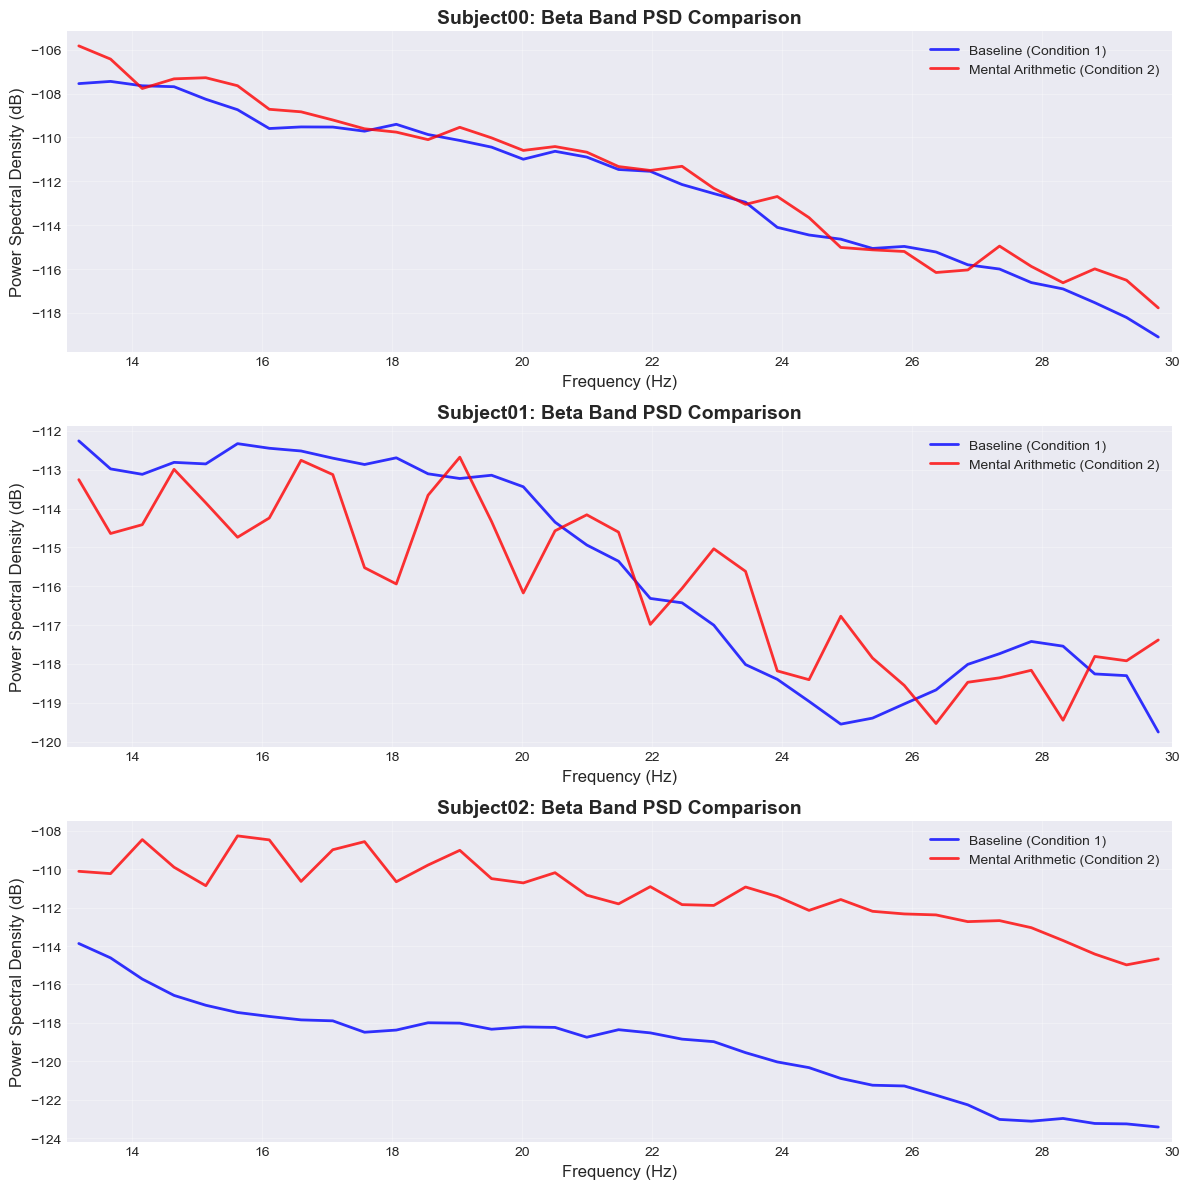

In [79]:
fig, axes = plt.subplots(len(subject_names), 1, figsize=(12, 4*len(subject_names)))
if len(subject_names) == 1:
    axes = [axes]

for idx, subject in enumerate(subject_names):
    ax = axes[idx]

    # Average PSD across all channels
    psd_baseline_mean = np.mean(psd_baseline_all[idx], axis=0)
    psd_task_mean = np.mean(psd_task_all[idx], axis=0)

    # Plot
    ax.plot(freqs, 10 * np.log10(psd_baseline_mean),
            label='Baseline (Condition 1)', linewidth=2, color='blue', alpha=0.8)
    ax.plot(freqs, 10 * np.log10(psd_task_mean),
            label='Mental Arithmetic (Condition 2)', linewidth=2, color='red', alpha=0.8)

    ax.set_xlabel('Frequency (Hz)', fontsize=12)
    ax.set_ylabel('Power Spectral Density (dB)', fontsize=12)
    ax.set_title(f'{subject}: Beta Band PSD Comparison', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(BETA_BAND)

plt.tight_layout()
plt.show()

## 6. Visualization: Grand Average PSD

Show the average PSD across all subjects with error bands:

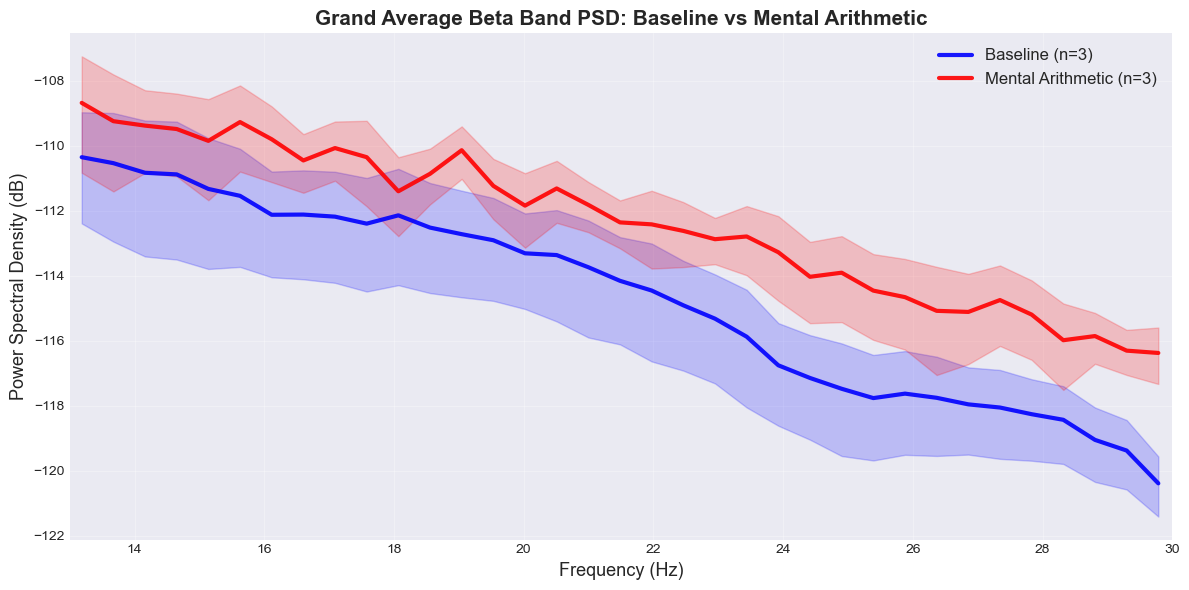

In [80]:
# Compute grand average across all subjects
grand_avg_baseline = np.mean([np.mean(psd, axis=0) for psd in psd_baseline_all], axis=0)
grand_avg_task = np.mean([np.mean(psd, axis=0) for psd in psd_task_all], axis=0)

# Compute standard error
grand_se_baseline = np.std([np.mean(psd, axis=0) for psd in psd_baseline_all], axis=0) / np.sqrt(len(psd_baseline_all))
grand_se_task = np.std([np.mean(psd, axis=0) for psd in psd_task_all], axis=0) / np.sqrt(len(psd_task_all))

fig, ax = plt.subplots(figsize=(12, 6))

# Plot with error bands
ax.plot(freqs, 10 * np.log10(grand_avg_baseline),
        label=f'Baseline (n={len(subject_names)})', linewidth=3, color='blue', alpha=0.9)
ax.fill_between(freqs,
                10 * np.log10(grand_avg_baseline - grand_se_baseline),
                10 * np.log10(grand_avg_baseline + grand_se_baseline),
                alpha=0.2, color='blue')

ax.plot(freqs, 10 * np.log10(grand_avg_task),
        label=f'Mental Arithmetic (n={len(subject_names)})', linewidth=3, color='red', alpha=0.9)
ax.fill_between(freqs,
                10 * np.log10(grand_avg_task - grand_se_task),
                10 * np.log10(grand_avg_task + grand_se_task),
                alpha=0.2, color='red')

ax.set_xlabel('Frequency (Hz)', fontsize=13)
ax.set_ylabel('Power Spectral Density (dB)', fontsize=13)
ax.set_title('Grand Average Beta Band PSD: Baseline vs Mental Arithmetic',
             fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xlim(BETA_BAND)

plt.tight_layout()
plt.show()

## 7. PSD Topoplot Heatmaps

Visualize the spatial distribution of beta band power across the scalp using topographic maps. These topoplots show which brain regions have the highest beta activity.

In [81]:
# Define standard 10-20 EEG channel names that have positions in the montage
standard_eeg_channels = [
    'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
    'T7', 'C3', 'Cz', 'C4', 'T8',
    'P7', 'P3', 'Pz', 'P4', 'P8',
    'O1', 'O2'
]

# Find which channels from our data are in the standard set
valid_ch_indices = []
valid_ch_names = []
for i, ch in enumerate(ch_names_common):
    if ch in standard_eeg_channels:
        valid_ch_indices.append(i)
        valid_ch_names.append(ch)

print(f"Found {len(valid_ch_names)} valid EEG channels for topoplot: {valid_ch_names}")

# Create an MNE Info object for plotting with only the valid channels
# First, create a temporary info object with all common channel names
temp_info = mne.create_info(ch_names=ch_names_common, sfreq=all_baseline[0].info['sfreq'], ch_types='eeg')
montage = mne.channels.make_standard_montage('standard_1020')
temp_info.set_montage(montage, on_missing='ignore', match_case=False)

# Now, filter this info object to only include the valid channels for topoplotting
info = mne.pick_info(temp_info, [temp_info.ch_names.index(ch) for ch in valid_ch_names])

# Compute average beta power per channel across all subjects
beta_power_baseline_all_ch = np.mean([np.mean(psd, axis=1) for psd in psd_baseline_all], axis=0)
beta_power_task_all_ch = np.mean([np.mean(psd, axis=1) for psd in psd_task_all], axis=0)

# Filter to only valid channels for topoplot
beta_power_baseline_channels = beta_power_baseline_all_ch[valid_ch_indices]
beta_power_task_channels = beta_power_task_all_ch[valid_ch_indices]

# Convert to dB for better visualization
beta_power_baseline_db = 10 * np.log10(beta_power_baseline_channels)
beta_power_task_db = 10 * np.log10(beta_power_task_channels)
beta_power_diff_db = beta_power_task_db - beta_power_baseline_db

print(f"\nBeta power computed for {len(valid_ch_names)} channels")
print(f"Baseline range: {beta_power_baseline_db.min():.2f} to {beta_power_baseline_db.max():.2f} dB")
print(f"Task range: {beta_power_task_db.min():.2f} to {beta_power_task_db.max():.2f} dB")
print(f"Difference range: {beta_power_diff_db.min():.2f} to {beta_power_diff_db.max():.2f} dB")

Found 19 valid EEG channels for topoplot: ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'T7', 'T8', 'C3', 'C4', 'P7', 'P8', 'P3', 'P4', 'O1', 'O2', 'Fz', 'Cz', 'Pz']

Beta power computed for 19 channels
Baseline range: -121.37 to -117.69 dB
Task range: -120.41 to -116.54 dB
Difference range: -0.96 to 1.55 dB


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 509 samples (1.018 s)



Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 181 events and 1000 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 509 samples (1.018 s)

Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 1000 original time points ...
0 bad epochs dropped


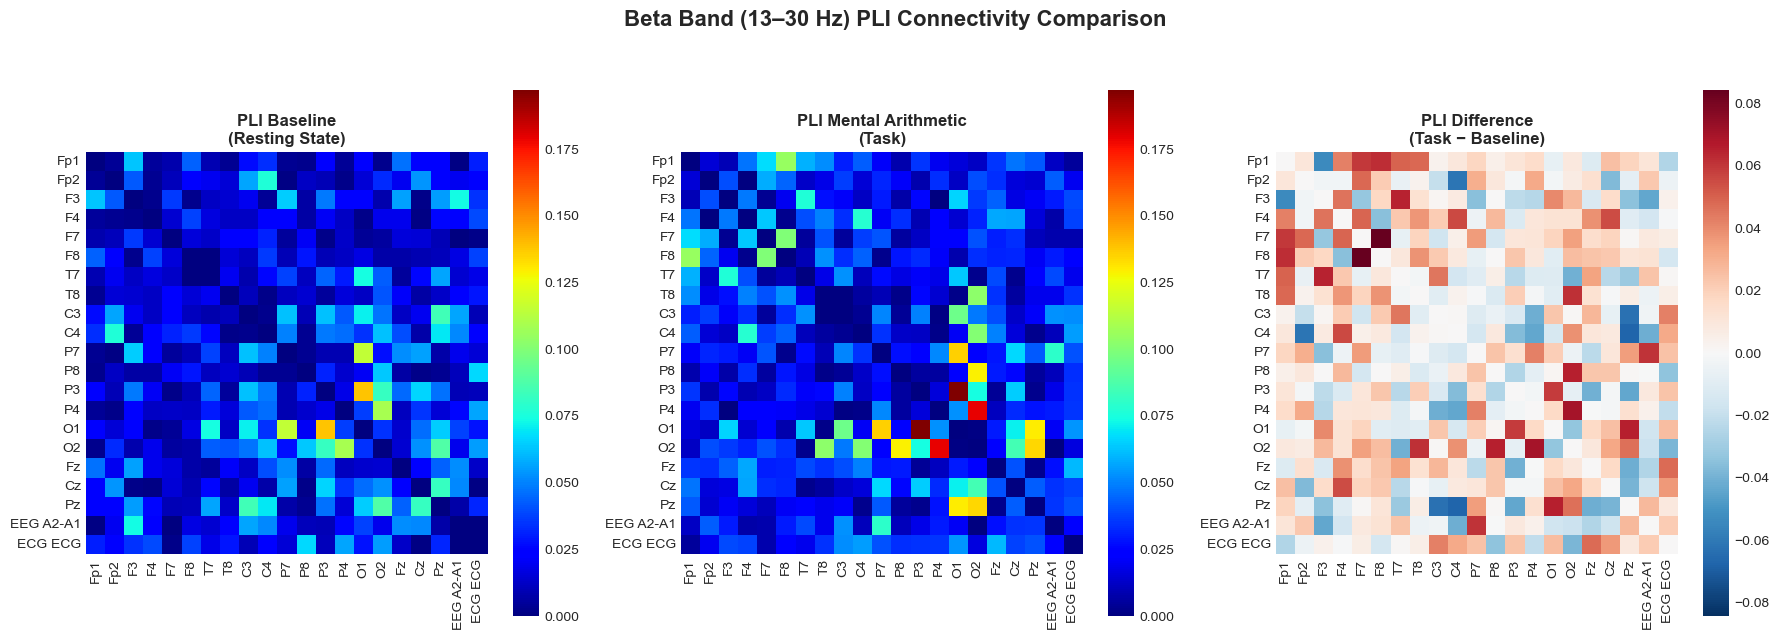

In [82]:
# Helper: Compute PLI
def compute_pli(data):
    n_epochs, n_channels, _ = data.shape
    pli = np.zeros((n_channels, n_channels))

    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            signs = []
            for ep in range(n_epochs):
                phase_i = np.angle(hilbert(data[ep, i]))
                phase_j = np.angle(hilbert(data[ep, j]))
                signs.append(np.sign(np.sin(phase_i - phase_j)))

            pli_val = np.abs(np.mean(np.concatenate(signs)))
            pli[i, j] = pli_val
            pli[j, i] = pli_val

    return pli

# Preprocess + Epoch (Beta)
def get_pli_from_raw(raw):
    raw_beta = raw.copy().filter(13., 30., fir_design='firwin')
    epochs = mne.make_fixed_length_epochs(
        raw_beta,
        duration=2.0,
        overlap=1.0,
        preload=True
    )
    return compute_pli(epochs.get_data()), epochs.ch_names

# Compute connectivity
pli_baseline, ch_names = get_pli_from_raw(raw_baseline)
pli_task, _ = get_pli_from_raw(raw_task)

pli_diff = pli_task - pli_baseline

# Common color scales
vmin_common = min(pli_baseline.min(), pli_task.min())
vmax_common = max(pli_baseline.max(), pli_task.max())
vmax_diff = max(abs(pli_diff.min()), abs(pli_diff.max()))

# Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(
    pli_baseline, ax=axes[0], cmap='jet',
    vmin=vmin_common, vmax=vmax_common,
    square=True, xticklabels=ch_names, yticklabels=ch_names
)
axes[0].set_title('PLI Baseline\n(Resting State)', fontweight='bold')

sns.heatmap(
    pli_task, ax=axes[1], cmap='jet',
    vmin=vmin_common, vmax=vmax_common,
    square=True, xticklabels=ch_names, yticklabels=ch_names
)
axes[1].set_title('PLI Mental Arithmetic\n(Task)', fontweight='bold')

sns.heatmap(
    pli_diff, ax=axes[2], cmap='RdBu_r',
    center=0, vmin=-vmax_diff, vmax=vmax_diff,
    square=True, xticklabels=ch_names, yticklabels=ch_names
)
axes[2].set_title('PLI Difference\n(Task − Baseline)', fontweight='bold')

fig.suptitle(
    'Beta Band (13–30 Hz) PLI Connectivity Comparison',
    fontsize=16, fontweight='bold', y=1.05
)

plt.tight_layout()
plt.show()

### 7.1 Side-by-Side Heatmap Comparison

Compare all three topoplots in a single figure:

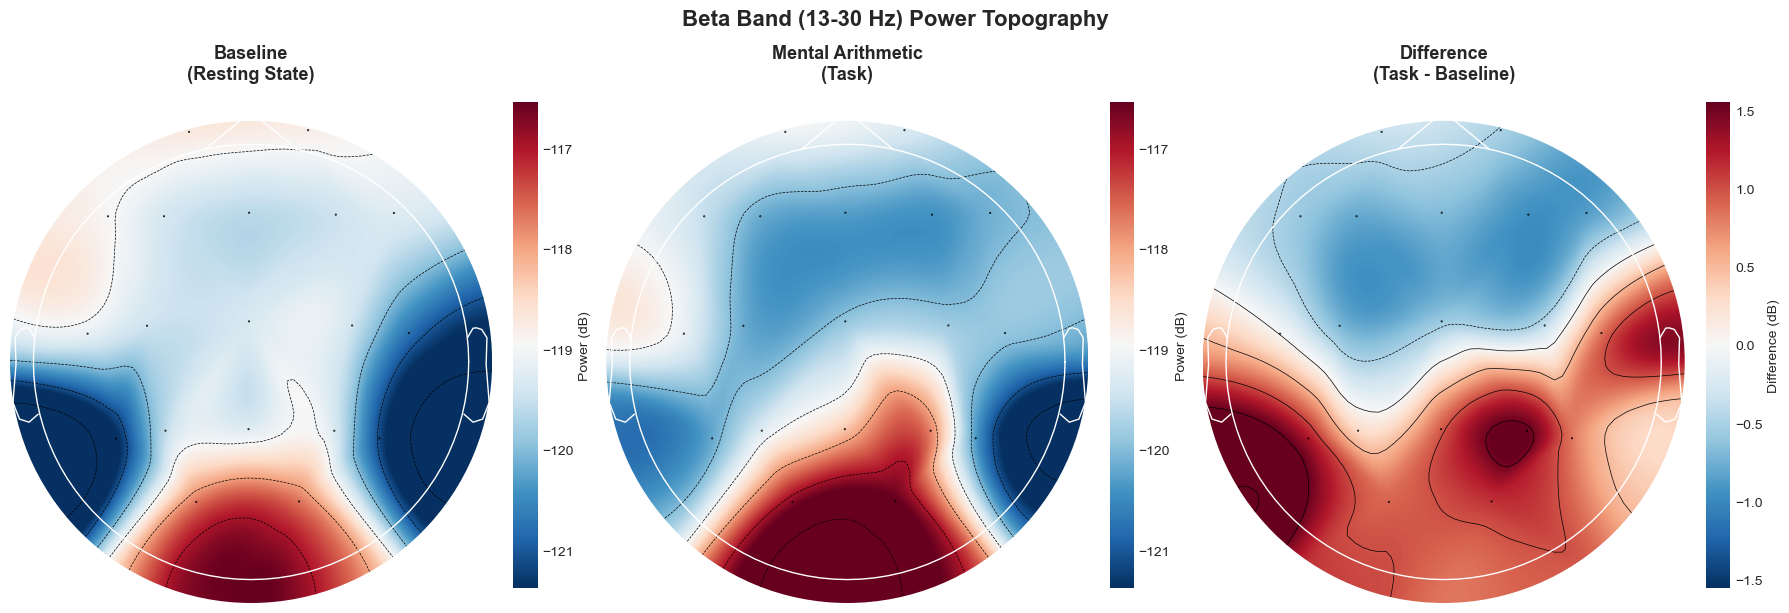

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Common color scale for baseline and task
vmin_common = min(beta_power_baseline_db.min(), beta_power_task_db.min())
vmax_common = max(beta_power_baseline_db.max(), beta_power_task_db.max())

# Baseline
im1, _ = mne.viz.plot_topomap(
    beta_power_baseline_db,
    info,
    axes=axes[0],
    show=False,
    cmap='RdBu_r',
    vlim=(vmin_common, vmax_common),
    contours=6,
    sensors=True
)
axes[0].set_title('Baseline\n(Resting State)', fontsize=13, fontweight='bold')

# Task
im2, _ = mne.viz.plot_topomap(
    beta_power_task_db,
    info,
    axes=axes[1],
    show=False,
    cmap='RdBu_r',
    vlim=(vmin_common, vmax_common),
    contours=6,
    sensors=True
)
axes[1].set_title('Mental Arithmetic\n(Task)', fontsize=13, fontweight='bold')

# Difference
vmax_diff = max(abs(beta_power_diff_db.min()), abs(beta_power_diff_db.max()))
im3, _ = mne.viz.plot_topomap(
    beta_power_diff_db,
    info,
    axes=axes[2],
    show=False,
    cmap='RdBu_r',
    vlim=(-vmax_diff, vmax_diff),
    contours=6,
    sensors=True
)
axes[2].set_title('Difference\n(Task - Baseline)', fontsize=13, fontweight='bold')

# Add colorbars
cbar1 = plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
cbar1.set_label('Power (dB)', fontsize=10)
cbar2 = plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
cbar2.set_label('Power (dB)', fontsize=10)
cbar3 = plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
cbar3.set_label('Difference (dB)', fontsize=10)

fig.suptitle('Beta Band (13-30 Hz) Power Topography', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 8. Summary Statistics

Calculate average beta power for each subject and condition:

In [84]:
# Calculate average beta power for each subject
# Convert to microvolts squared per Hz for more readable values
beta_power_baseline = []
beta_power_task = []

for idx in range(len(subject_names)):
    # Average across channels and frequencies, convert V^2/Hz to uV^2/Hz
    baseline_power = np.mean(psd_baseline_all[idx]) * 1e12  # V^2 to uV^2
    task_power = np.mean(psd_task_all[idx]) * 1e12
    beta_power_baseline.append(baseline_power)
    beta_power_task.append(task_power)

print("Beta Band Power (averaged across channels and frequencies):")
print("=" * 70)
print(f"{'Subject':<15} {'Baseline (uV^2/Hz)':<20} {'Task (uV^2/Hz)':<20} {'Diff (uV^2/Hz)':<15}")
print("=" * 70)

for idx, subject in enumerate(subject_names):
    diff = beta_power_task[idx] - beta_power_baseline[idx]
    print(f"{subject:<15} {beta_power_baseline[idx]:<20.4f} "
          f"{beta_power_task[idx]:<20.4f} {diff:<+15.4f}")

print("=" * 70)
avg_baseline = np.mean(beta_power_baseline)
avg_task = np.mean(beta_power_task)
avg_diff = avg_task - avg_baseline
pct_change = (avg_diff / avg_baseline) * 100 if avg_baseline != 0 else 0

print(f"{'AVERAGE':<15} {avg_baseline:<20.4f} {avg_task:<20.4f} {avg_diff:<+15.4f}")
print(f"\nPercentage change (Task vs Baseline): {pct_change:+.2f}%")

# Also show in dB
print("\n" + "=" * 70)
print("Power in dB (10*log10):")
print("=" * 70)
print(f"{'Subject':<15} {'Baseline (dB)':<20} {'Task (dB)':<20} {'Diff (dB)':<15}")
print("=" * 70)

for idx, subject in enumerate(subject_names):
    baseline_db = 10 * np.log10(beta_power_baseline[idx])
    task_db = 10 * np.log10(beta_power_task[idx])
    diff_db = task_db - baseline_db
    print(f"{subject:<15} {baseline_db:<20.2f} {task_db:<20.2f} {diff_db:<+15.2f}")

avg_baseline_db = 10 * np.log10(avg_baseline)
avg_task_db = 10 * np.log10(avg_task)
avg_diff_db = avg_task_db - avg_baseline_db
print("=" * 70)
print(f"{'AVERAGE':<15} {avg_baseline_db:<20.2f} {avg_task_db:<20.2f} {avg_diff_db:<+15.2f}")

print(f"\n{'='*70}")
print("INTERPRETATION")
print(f"{'='*70}")
print(f"""\nBeta band (13-30 Hz) is associated with:
- Active thinking and concentration
- Problem-solving and cognitive processing
- Alertness and focused attention

Expected: Beta power should INCREASE during mental arithmetic
Observed: {pct_change:+.2f}% change ({avg_diff_db:+.2f} dB)
Result: {'As expected - beta power increased during cognitive task!' if pct_change > 0 else 'Unexpected - further analysis needed'}""")

Beta Band Power (averaged across channels and frequencies):
Subject         Baseline (uV^2/Hz)   Task (uV^2/Hz)       Diff (uV^2/Hz) 
Subject00       7.7836               8.8091               +1.0254        
Subject01       3.2795               2.8676               -0.4119        
Subject02       1.3703               8.1669               +6.7966        
AVERAGE         4.1445               6.6145               +2.4701        

Percentage change (Task vs Baseline): +59.60%

Power in dB (10*log10):
Subject         Baseline (dB)        Task (dB)            Diff (dB)      
Subject00       8.91                 9.45                 +0.54          
Subject01       5.16                 4.58                 -0.58          
Subject02       1.37                 9.12                 +7.75          
AVERAGE         6.17                 8.20                 +2.03          

INTERPRETATION

Beta band (13-30 Hz) is associated with:
- Active thinking and concentration
- Problem-solving and cognitive pr